In [1]:
# Make sure to install the requirements with pip install -r requirements.txt
import os
from matplotlib import pyplot as plt
import numpy as np
import torch
import yaml
from argparse import Namespace
from tqdm.notebook import tqdm
from lib.model import get_model_and_optim
from lib.data import prepare_nuclear_data
from lib.utils import preds_targets_zn, PlottingContext, IO, get_rms, get_rms_no_outliers
from sklearn.decomposition import PCA
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('paper')

In [2]:
location = f"{IO.get_root()}/binding_2/"
args = IO.load_args(f"{location}/args.yaml")
data = prepare_nuclear_data(args)
new_model = get_model_and_optim(data, args)[0]
new_model.load_state_dict(torch.load(f"{location}/ckpts/model-45000.pt"))
model_name = 'binding'if 'binding' in location else 'all'

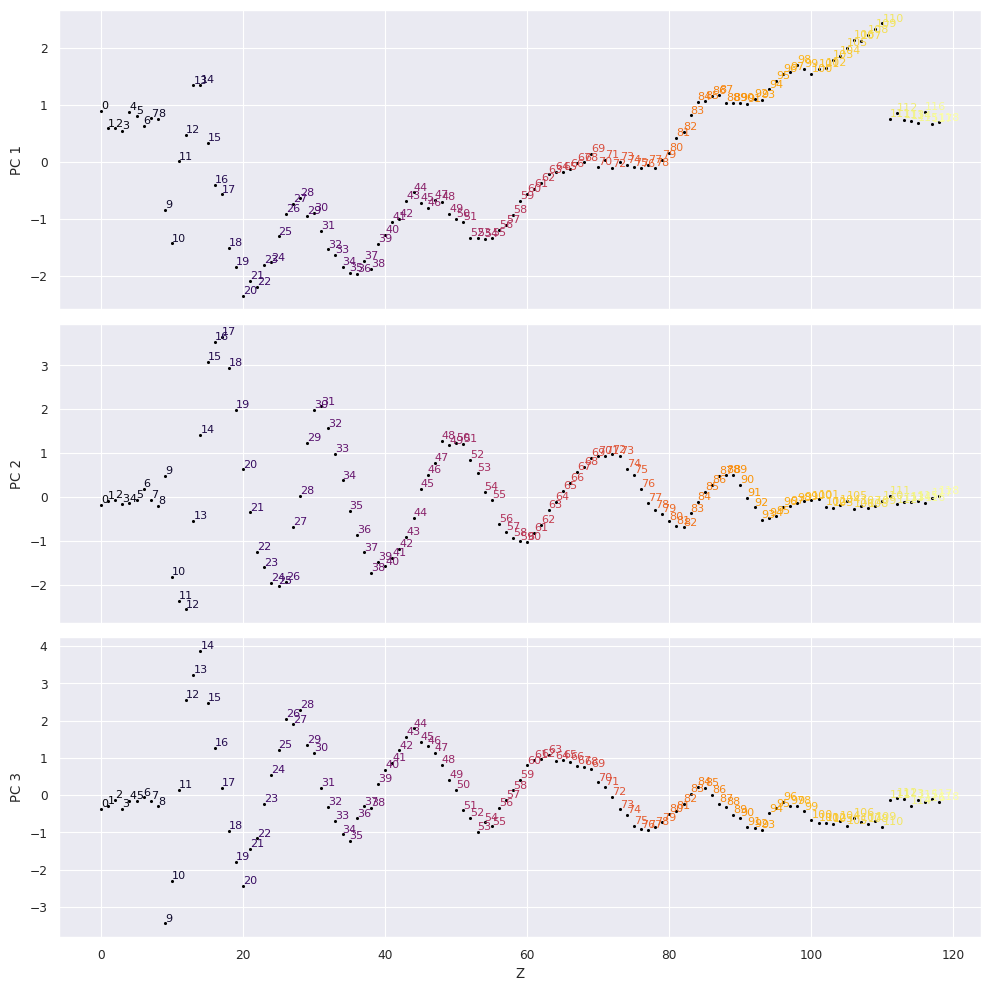

In [3]:
# let's take a look at our embeddings
for i, nucleon in enumerate(["Z", "N"]):
    embed = new_model.emb[i].detach().cpu().numpy()

    pca = PCA(n_components=(n_components:=3))
    embed = pca.fit_transform(embed)
    colors = plt.cm.inferno(np.linspace(0, 1, len(embed)))

    fig, axes = plt.subplots(n_components, 1, figsize=(10, 10), sharex=True)
    axes = axes.flatten()
    for i in range(0, n_components):
        ax = axes[i]
        x, y = np.arange(len(embed)), embed[:, i]
        ax.scatter(x, y, s=2, c='k')
        PlottingContext.scatter_text(np.arange(len(embed)), x, y, colors=colors, ax=ax, fontsize=8)
        ax.set_ylabel(f"PC {i+1}")

    ax.set_xlabel(nucleon)
    fig.tight_layout()
    plt.savefig(f"plots/paper/{model_name}_embeddings_{nucleon}.pdf")
    plt.show()
    break



In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = data.X[~torch.isnan(data.y).view(-1)]
y_train = data.y[~torch.isnan(data.y).view(-1)]

X_train, y_train = X_train[X_train[:, 2] == 0],  y_train[X_train[:, 2] == 0]

# Save the last layer activations
acts = torch.zeros(len(X_train), 2048, device=device)
# save the activations fed into the readout layer
hook = new_model.readout.register_forward_pre_hook(lambda m, i: acts.copy_(i[0].detach()))
new_model(X_train)
hook.remove()

def inverse_transform(vector, index):
    """inverse transform the vector to the original scale"""
    scale = data.regression_transformer.data_max_[index] - data.regression_transformer.data_min_[index]
    min_ = data.regression_transformer.data_min_[index]
    vector = vector * scale + min_
    return vector

# Ensure that the RMS is the same as the franken model
def get_preds_from_last_acts(acts):
    preds = new_model.readout(acts) #- new_model.readout.bias
    preds = preds.detach().cpu().numpy()
    preds = data.regression_transformer.inverse_transform(preds)
    # preds = preds / data.regression_transformer.scale_ # + data.regression_transformer.min_
    return preds[:, 0]

def get_rms_from_last_acts(acts):
    preds = get_preds_from_last_acts(acts)
    targets = y_train.detach().cpu().numpy().reshape(-1)
    targets = inverse_transform(targets, 0)
    zn = X_train[:, :2].detach().cpu().numpy()
    rms = get_rms(preds, targets, zn, scale_by_A=True)
    return rms
print(f"RMS recomputed: {get_rms_from_last_acts(acts):.2f}")

RMS recomputed: 2017462.62


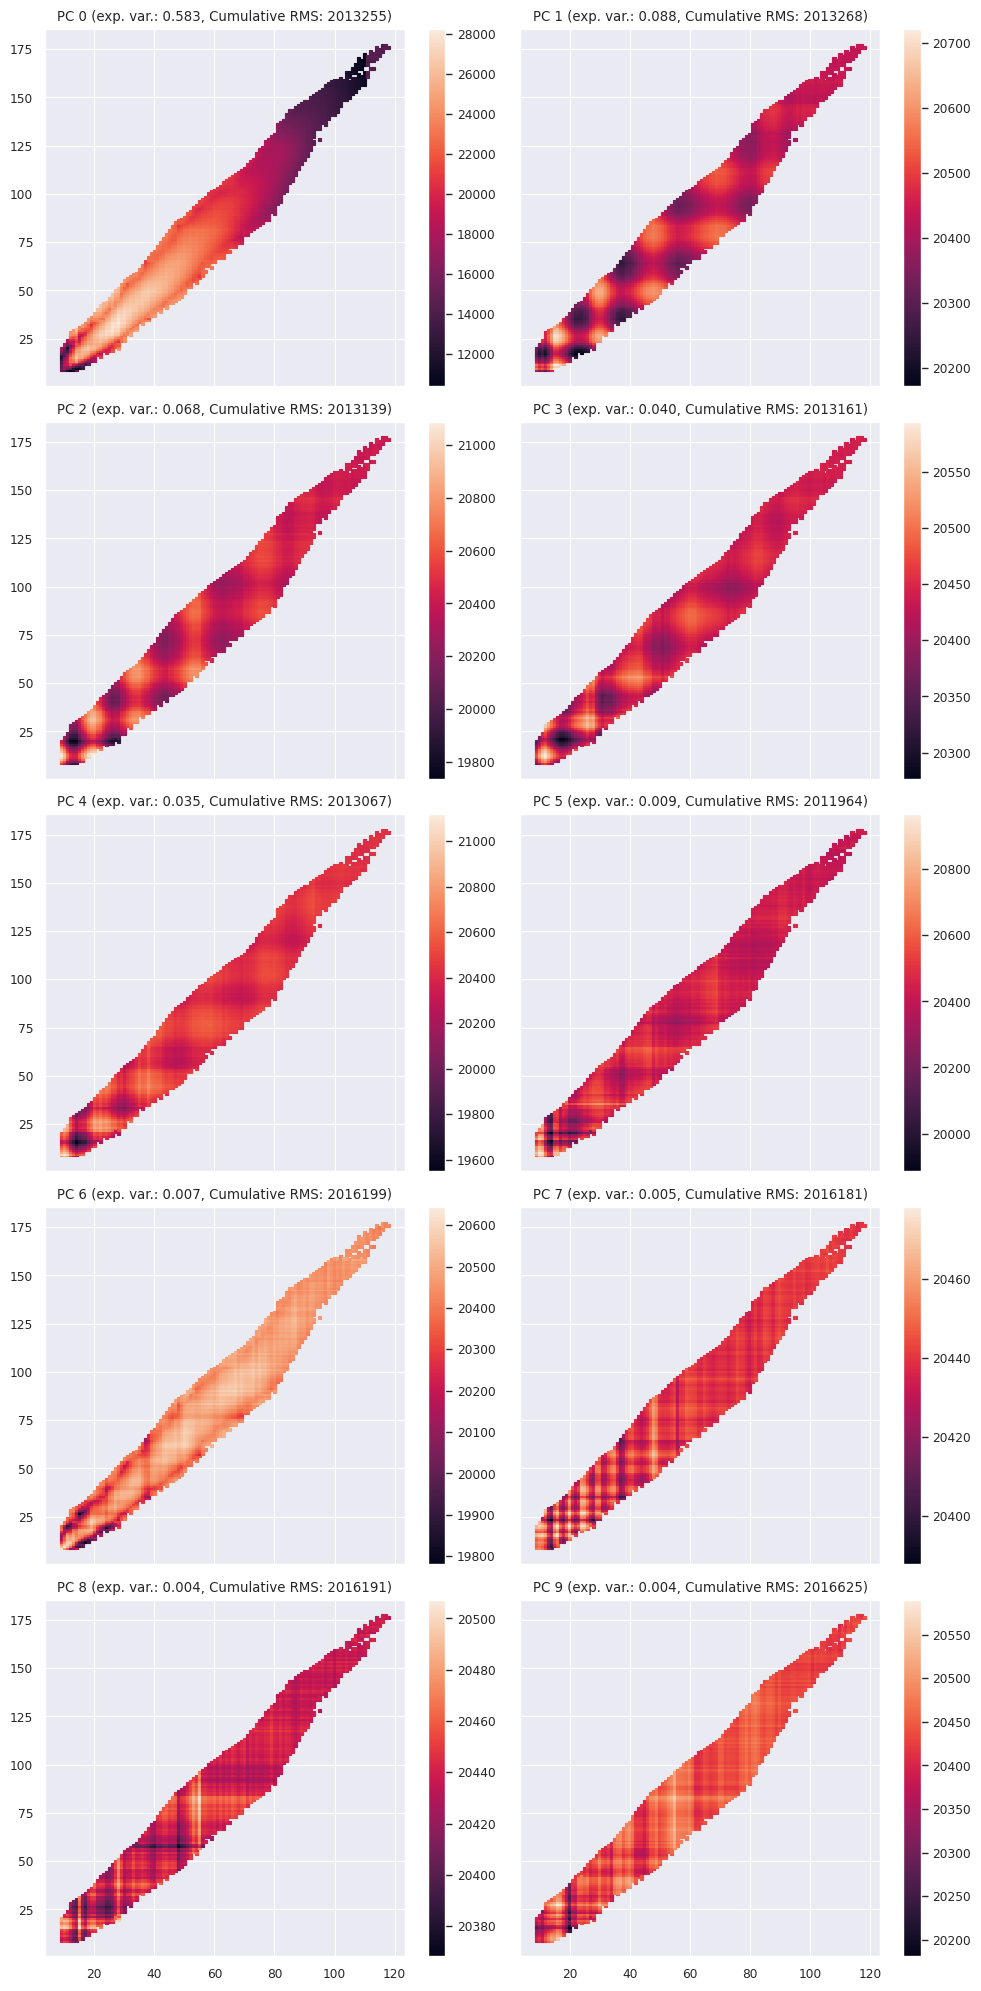

In [5]:
pca = PCA(n_components=100)
acts_pca = pca.fit_transform(acts.cpu().numpy(), y_train.detach().cpu().numpy().flatten())
# let's visualize all the PCs as a function of input
num_plots = min(acts_pca.shape[1], 10)
fig, axes = plt.subplots(max(num_plots//2, 1), 2, figsize=(10, 2 * num_plots), sharex=True, sharey=True)
axes = axes.flatten()
Z, N = X_train[:, 0].detach().cpu().numpy(), X_train[:, 1].detach().cpu().numpy()
scale = data.regression_transformer.data_max_ - data.regression_transformer.data_min_
min_ = data.regression_transformer.data_min_

features = []
for i in range(num_plots):
    # get rms for the current PC
    acts_pca_ = acts_pca.copy()
    acts_pca_[:, i+1:] = 0
    acts_pca_cumulative = pca.inverse_transform(acts_pca_)
    acts_pca_cumulative = torch.tensor(acts_pca_cumulative, device=device, dtype=torch.float32)
    rms = get_rms_from_last_acts(acts_pca_cumulative)
    # plot
    ax = axes.flatten()[i]
    acts_pca_[:, :i] = 0
    acts_pca_singular = pca.inverse_transform(acts_pca_)
    acts_pca_singular = torch.tensor(acts_pca_singular, device=device, dtype=torch.float32)
    color = new_model.readout(acts_pca_singular).detach().cpu().numpy()
    color = (color * scale + min_)[:, 0]
    # color = get_preds_from_last_acts(acts_pca_singular)
    features.append(color)
    sc = ax.scatter(Z, N, c=color, s=5, marker='s')
    ax.set_title(f"PC {i} (exp. var.: {pca.explained_variance_ratio_[i]:.3f}, Cumulative RMS: {rms:.0f})")
    fig.colorbar(sc, ax=ax)
fig.tight_layout()
fig.savefig(f"plots/paper/{model_name}_features.pdf")
